In this benchmark, we try to achieve the highest throughput (MB/s) while reading a single ROOT file.

In [1]:
import os, sys
sys.path.append(os.getcwd()+"/../")
import copy
import yaml
from src.utils import recreate_dir
from src.benchmark import Benchmark, run_benchmark

In [2]:
default_config = {
    'data-access': {
        'mode': 'explicit-files',
        'files': []
    },
    'executor': {
        'backend': 'sequential',
        'n_workers': 1
    },
    'processor': {
        'parallelize_over': 'files',
        'columns': {},
        'load_columns_into_memory': True,
        'worker_operation_time': 0
    }
}

In [3]:
file_name = "90322FC2-4027-0E47-92E4-22307EC8EAD2.root"
file_locations = {
    "depot": "/depot/cms/users/dkondra/",
    "work": "/work/projects/purdue-af/",
    "eos_fuse": "/eos/purdue/store/data/Run2016B/SingleMuon/NANOAOD/02Apr2020_ver2-v1/20000/",
    "xrootd": "root://eos.cms.rcac.purdue.edu:1094//store/data/Run2016B/SingleMuon/NANOAOD/02Apr2020_ver2-v1/20000/",
    "xcache": "root://cms-xcache.rcac.purdue.edu:1094//store/data/Run2016B/SingleMuon/NANOAOD/02Apr2020_ver2-v1/20000/"
}

column_presets = {
    # "100pct": {
    #     # the bechmark will limit this to actual total number of columns
    #     "method": "n_columns",
    #     "values": 100000
    # },
    # "50pct": {
    #     "method": "collections",
    #     "values": ["Jet", "Photon", "Tau", "Electron", "Muon"]
    # },
    "10pct": {
        "method": "collections",
        "values": ["Muon"]
    },
    "5pct": {
        "method": "column_list",
        "values": [
            "run", "luminosityBlock", "HLT_IsoMu24", "PV_npvsGood", "fixedGridRhoFastjetAll",
            "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", "Muon_charge", "Muon_pfRelIso04_all", "Muon_mediumId", "Muon_ptErr",
            "Electron_pt", "Electron_eta", "Electron_mvaFall17V2Iso_WP90",
            "Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass",
        ]
    }
}

In [4]:
def generate_configs(save_dir="./"):
    recreate_dir(save_dir)

    iconf = 0
    repeat = 3

    for f_label, file_loc in file_locations.items():
        for c_label, column_setup in column_presets.items():
            for irep in range(repeat):
                config = copy.deepcopy(default_config)
    
                config["data-access"]["files"] = [f"{file_loc}/{file_name}"]
                config["processor"]["columns"] = column_setup
    
                # Custom labels to save to output dataframe
                config["custom_labels"] = {
                    "file_location": f_label,
                    "column_setup": c_label
                }
    
                unique_label =  f"2p1_{f_label}_{c_label}_{irep}"
    
                config["unique_label"] = unique_label
                config_name = f'config_{unique_label}.yaml'
                
                with open(f'{save_dir}/{config_name}', 'w') as file:
                    yaml.dump(config, file, default_flow_style=False)
    
                iconf += 1

    print(f'Saved {iconf} config files to {save_dir}')

In [5]:
# warning: all YAML files will be deleted from config directory before proceeding
config_path = "./configs_2.1"
output_path = "./outputs_2.1"

In [6]:
generate_configs(config_path)

Directory ./configs_2.1 already exists, will clean all files from it.
Saved 30 config files to ./configs_2.1


In [7]:
report = run_benchmark(config_path, output_path)

Directory ./outputs_2.1 already exists, will clean all files from it.


100%|██████████| 30/30 [17:30<00:00, 35.01s/it]


In [8]:
report.sort_values(by=['column_setup', 'file_location']).reset_index(drop=True)

,n_files,n_columns_read,n_events,loaded_columns,worker_operation_time,executor,n_workers,compressed_bytes,uncompressed_bytes,time:run_processor,time:wait,time:decompress,column_setup,file_location
0,1,50,154321550,True,0,sequential,1,265594188,1129031467,30.459931,0.030563,24.061388,10pct,depot
1,1,50,154321550,True,0,sequential,1,265594188,1129031467,30.506349,0.031068,24.128228,10pct,depot
2,1,50,154321550,True,0,sequential,1,265594188,1129031467,30.462117,0.030792,24.097522,10pct,depot
3,1,50,154321550,True,0,sequential,1,265594188,1129031467,30.513377,0.030538,24.048350,10pct,eos_fuse
4,1,50,154321550,True,0,sequential,1,265594188,1129031467,30.442081,0.030833,24.080730,10pct,eos_fuse
5,1,50,154321550,True,0,sequential,1,265594188,1129031467,30.533058,0.030703,24.076658,10pct,eos_fuse
6,1,50,154321550,True,0,sequential,1,265594188,1129031467,34.893134,0.030747,24.201373,10pct,work
7,1,50,154321550,True,0,sequential,1,265594188,1129031467,30.539464,0.030596,24.140102,10pct,work
8,1,50,154321550,True,0,sequential,1,265594188,1129031467,30.569113,0.030507,24.164185,10pct,work
9,1,50,154321550,True,0,sequential,1,265594188,1129031467,32.927919,0.320015,24.198597,10pct,xcache


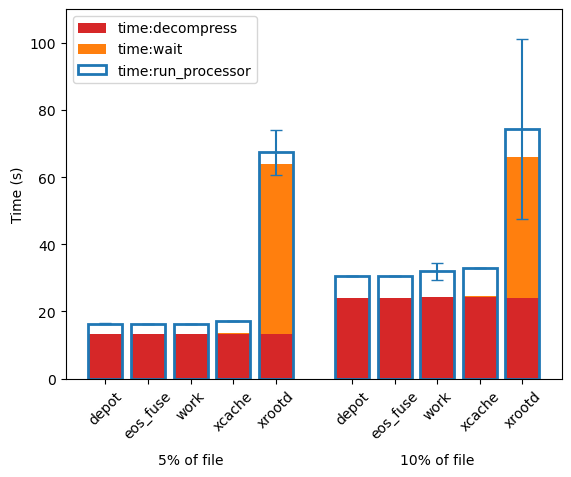

In [38]:
import matplotlib.pyplot as plt

report["MB/s (compressed)"] = report.compressed_bytes/report['time:run_processor']/(1024*1024)
report["column_setup"] = report["column_setup"].apply(lambda x: x.replace('pct', '% of the file'))

measurements = ["time:run_processor", "time:decompress", "time:wait", "MB/s (compressed)"]
other_cols = [c for c in report.columns if c not in measurements]

agg = {}
for c in report.columns:
    if c in measurements:
        agg[c] = ['mean', 'std']

aggregated = report.groupby(other_cols).agg(agg)


# Reset the index to make it easier to plot
aggregated_reset = aggregated.reset_index()
    

# Plotting
fig, ax = plt.subplots()

# Heights of the bars
decompress = aggregated_reset[('time:decompress', 'mean')]
wait = aggregated_reset[('time:wait', 'mean')]
run_processor = aggregated_reset[('time:run_processor', 'mean')]

# Error bars
run_processor_err = aggregated_reset[('time:run_processor', 'std')]

# Positions for bars
x = aggregated_reset[['file_location', 'column_setup']].reset_index(drop=True)

bar_width = 1

group_pos = 0
step = 1.25
group_gap = 1
mult = group_mult = 0

for col in x.column_setup.unique():
    for fl in x.file_location.unique():
        loc = (x.column_setup==col) & (x.file_location==fl)
        x.loc[loc, "position"] = group_pos + step * mult
        mult += 1
    group_pos += group_gap
    

# Plot the stacked bars
p1 = ax.bar(x.position, decompress, bar_width,label='time:decompress', color='tab:red', )
p2 = ax.bar(x.position, wait, bar_width, bottom=decompress, label='time:wait', color='tab:orange', )
p3 = ax.bar(x.position, run_processor, bar_width, yerr=run_processor_err, label='time:run_processor', 
            facecolor='none', linewidth=2, edgecolor='tab:blue', ecolor='tab:blue', capsize=4)

# Adding labels and title
# ax.set_xlabel('File location and fraction of the size')
ax.set_xticks(x.position, x.file_location)
ax.set_ylabel('Time (s)')
ax.set_ylim(0,110)
ax.set_title('')
ax.legend()
plt.xticks(rotation=45)

ax2 = ax.secondary_xaxis('bottom')
ax2_labels = x.groupby("column_setup").mean(numeric_only=True).reset_index()
ax2.set_xticks(ax2_labels.position, ax2_labels.column_setup)
ax2.spines['bottom'].set_position(('outward', 50))
ax2.spines['bottom'].set_visible(False)
ax2.tick_params(which='both', length=0)


plt.show()

In [ ]:
# report["event_rate"] = report.n_events / report.run_processor / report.n_columns_read
# report["data_rate_comp"] = report.compressed_bytes / report.run_processor
# report["data_rate_uncomp"] = report.uncompressed_bytes / report.run_processor
# report[["column_setup", "n_workers", "event_rate", "data_rate_comp", "data_rate_uncomp"]]

In [ ]:
# report.compressed_bytes / report.n_events  * report.n_columns_read